In [23]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga

import scbeta_scrnaseq.figure_vis as fv

from sklearn.neighbors import RadiusNeighborsRegressor, KernelDensity


from scbeta_scrnaseq.figure_vis import core_colors
fv.setup_matplotlib_params()
mm_per_inch = 25.4

Populating the interactive namespace from numpy and matplotlib


/Users/averes/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['xticks', 'gradient', 'fv']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import glob

pb_tpm = {}
for pbf in glob.glob('../*/data/complete_processing/*.pseudobulk_tpm.df.npz'):
    key = os.path.basename(pbf)[:-(len('.pseudobulk_tpm.df.npz'))]
    pb_tpm[key] = utils.load_df(pbf)
    
pb_expr = {}
for pbf in glob.glob('../*/data/complete_processing/*.expr_frac.df.npz'):
    key = os.path.basename(pbf)[:-(len('.expr_frac.df.npz'))]
    pb_expr[key] = utils.load_df(pbf)

In [3]:


cluster_order = [
    ('stage5.time_labels', '0__prog_nkx61', ),
    ('stage6.time_labels', '0__scbeta'),
    ('stage6.time_labels', '1__scbeta'),
    ('stage6.time_labels', '2__scbeta'),
    ('stage6.time_labels', '3__scbeta'),
    ('stage6.time_labels', '4__scbeta'),
    ('stage6.time_labels', '5__scbeta'),
    ('human_islets.labels', 'beta'),
    
]

In [4]:
cluster_tpm = utils.combine_rows(pb_tpm, cluster_order)
cluster_expr = utils.combine_rows(pb_expr, cluster_order)

In [5]:
importlib.reload(fv)

<module 'scbeta_scrnaseq.figure_vis' from '/Users/averes/Projects/Melton/Papers/Mapping_SCbeta/2019_02_04_final_version/code/scbeta_scrnaseq/figure_vis.py'>

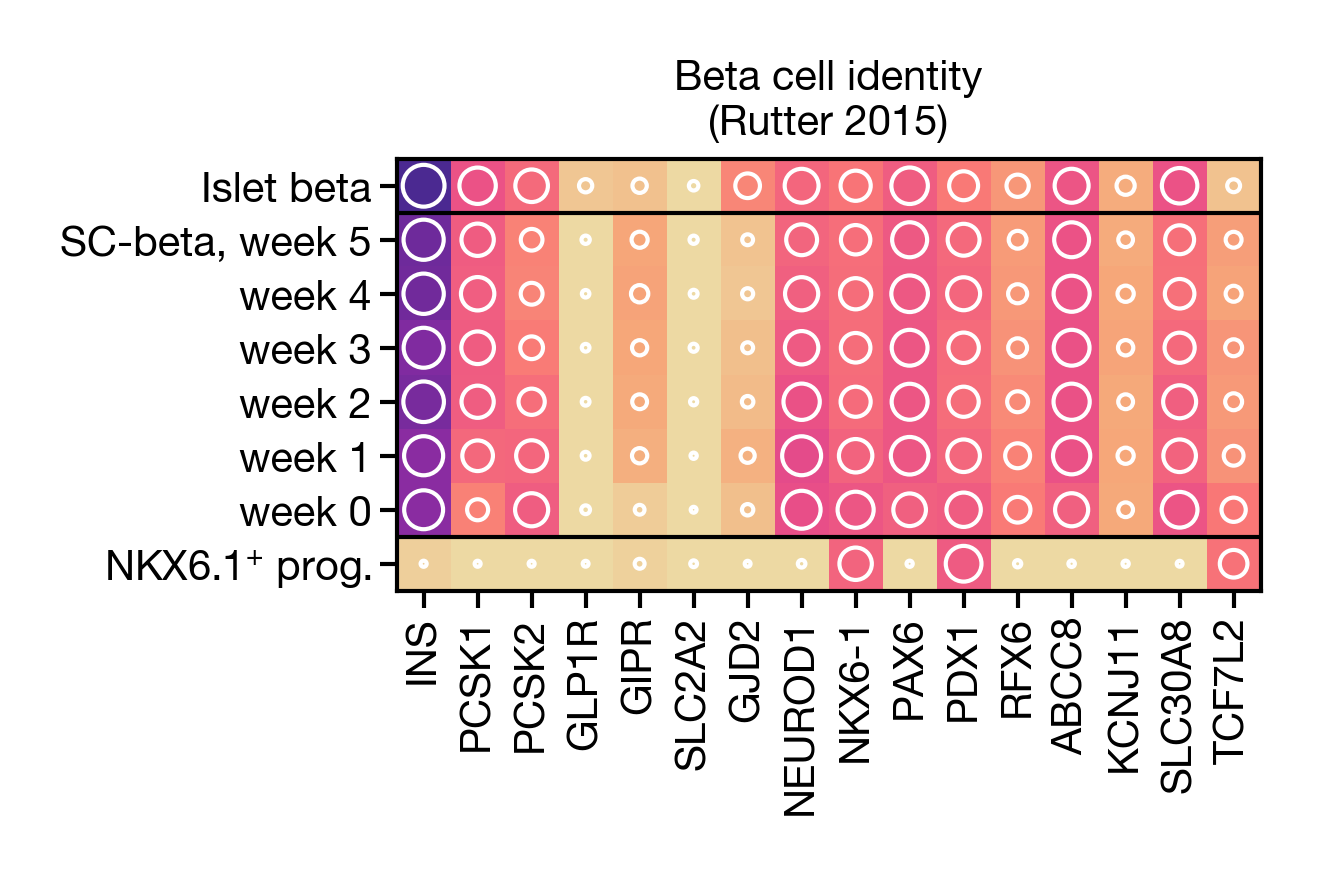

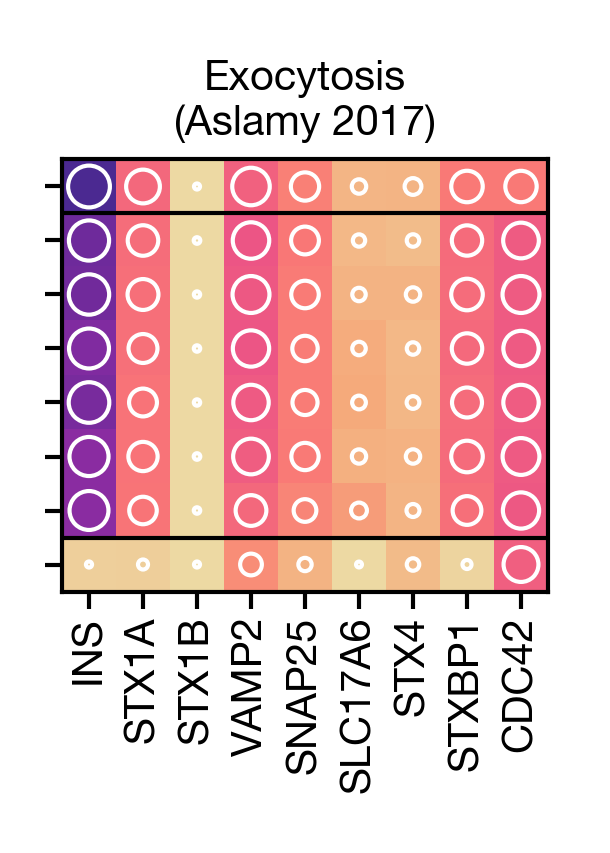

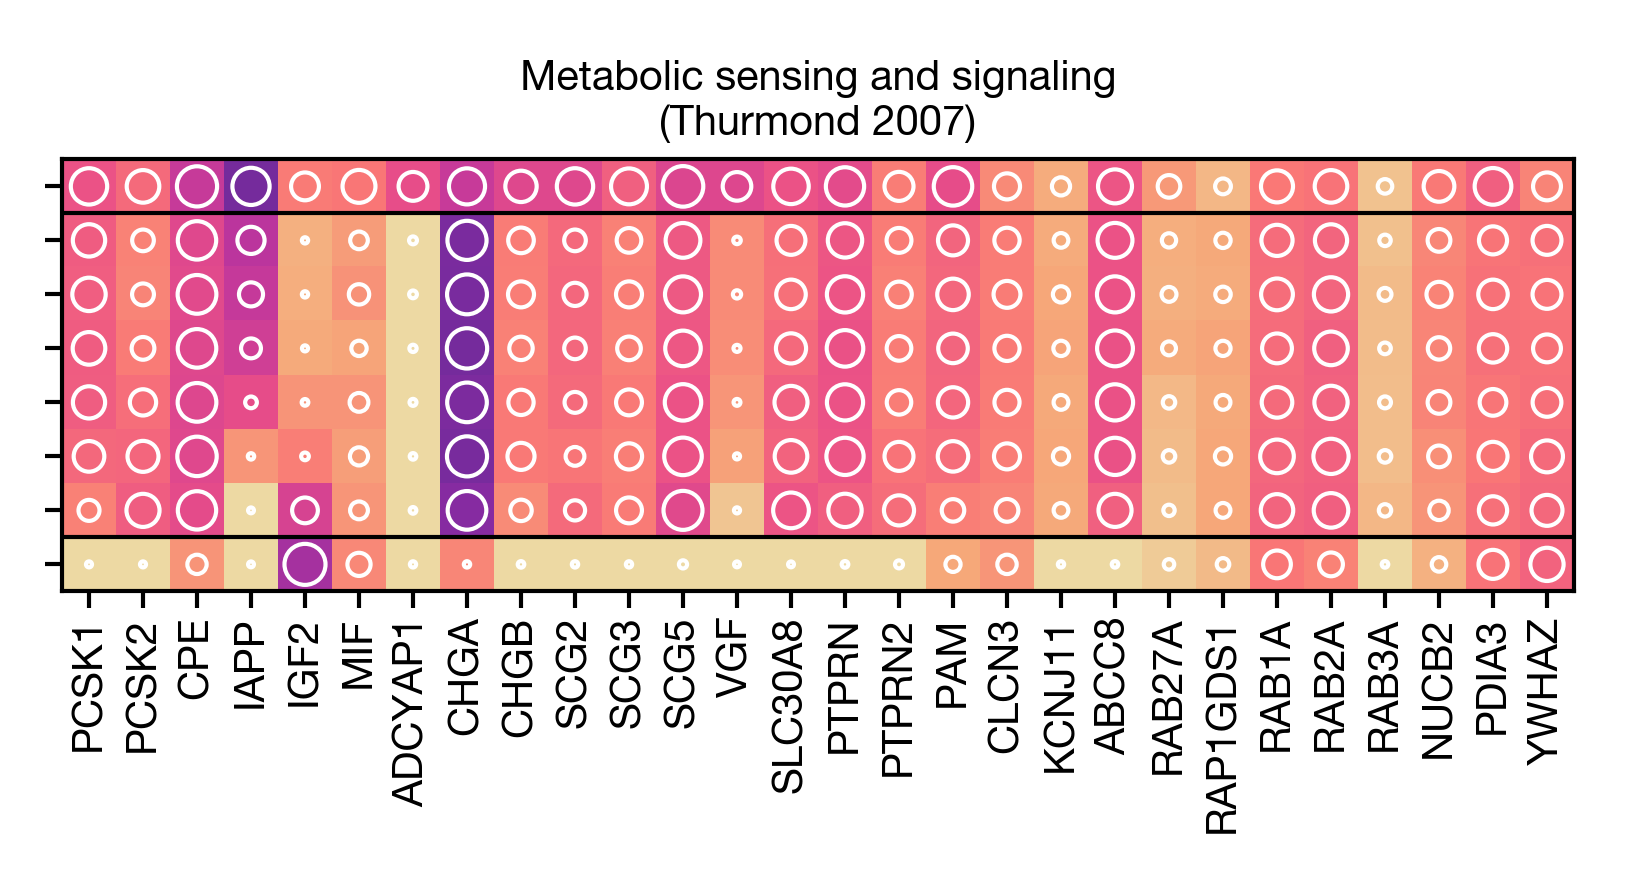

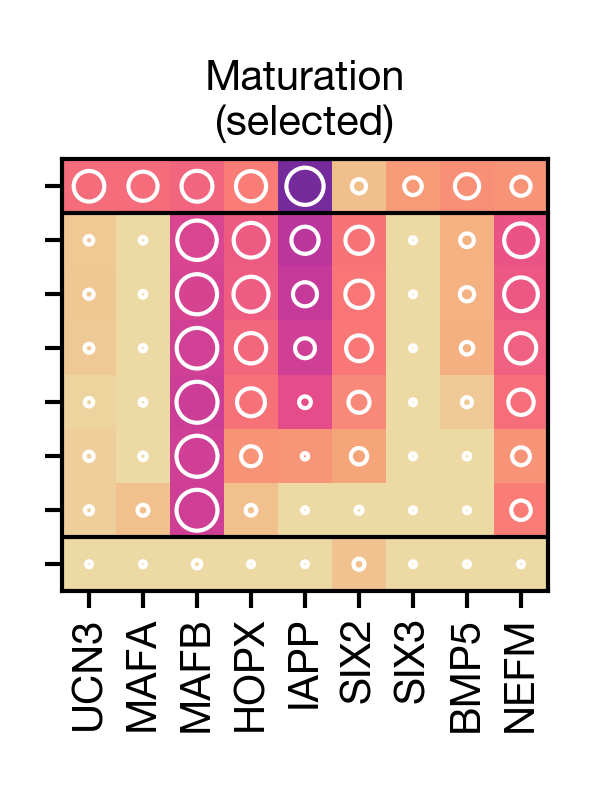

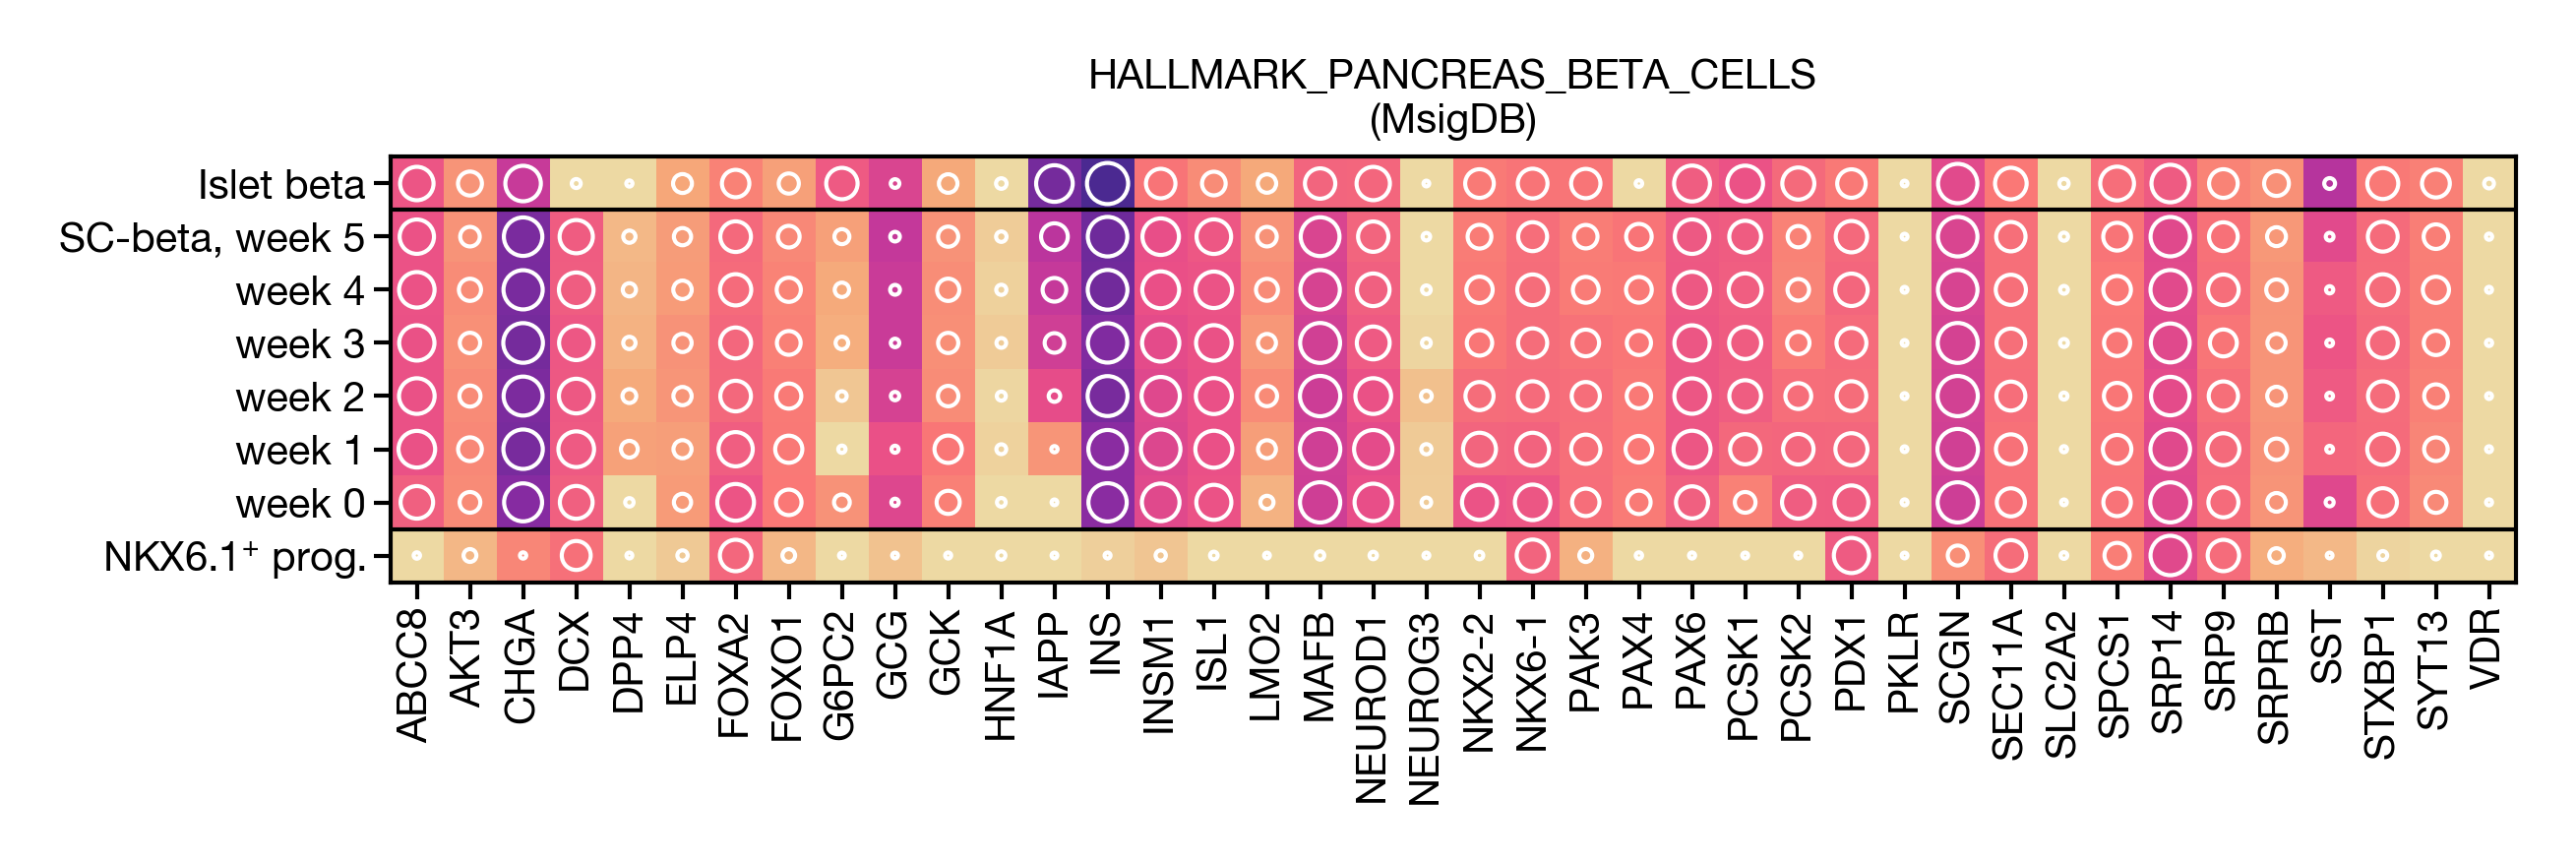

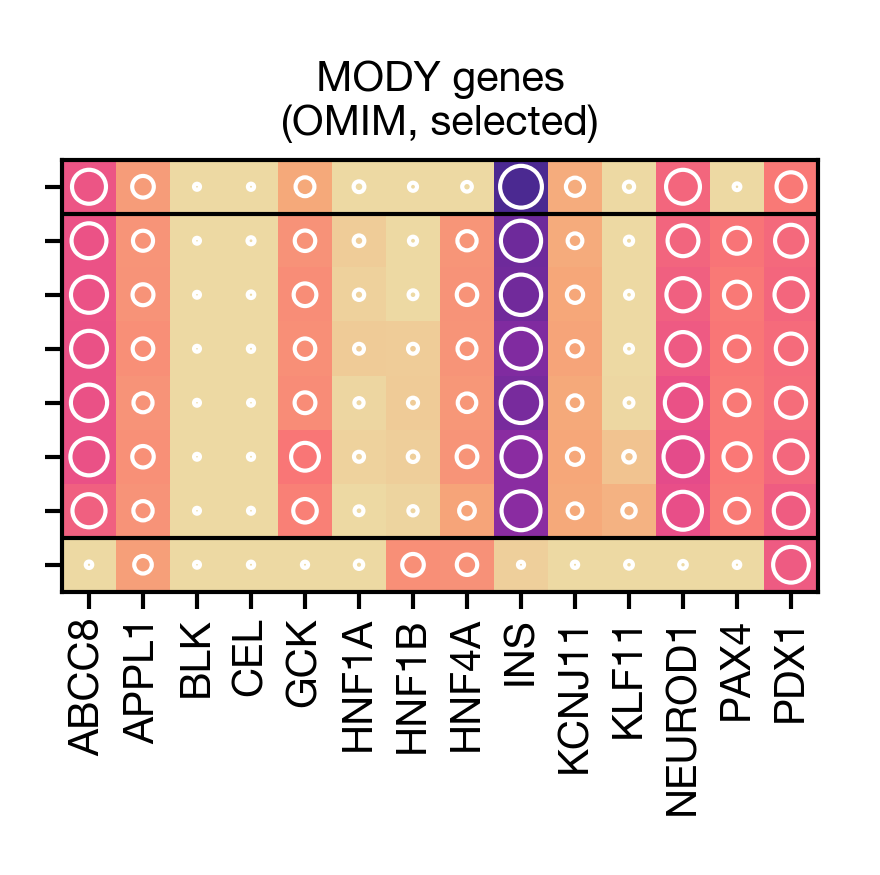

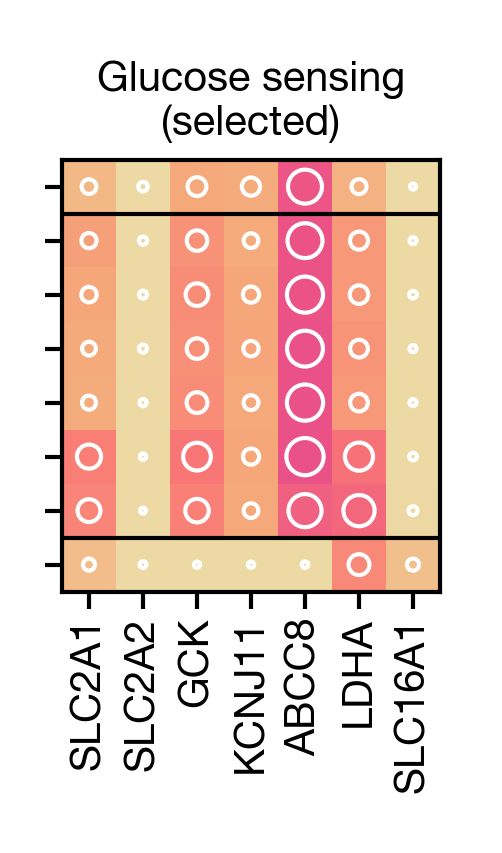

In [6]:
rcParams['axes.linewidth'] = 0.5

cmap = palettable.cartocolors.sequential.agSunset_7_r.get_mpl_colormap()

gene_display_groups = [
    ('Beta cell identity\n(Rutter 2015)', True, ["INS","PCSK1","PCSK2","GLP1R","GIPR","SLC2A2","GJD2","NEUROD1","NKX6-1","PAX6","PDX1","RFX6","ABCC8","KCNJ11","SLC30A8","TCF7L2",],),
    ('Exocytosis\n(Aslamy 2017)', False, ["INS", "STX1A","STX1B","VAMP2","SNAP25","SLC17A6","STX4","STXBP1","CDC42"], ),
    ('Metabolic sensing and signaling\n(Thurmond 2007)', False, ["PCSK1","PCSK2","CPE","IAPP","IGF2","MIF","ADCYAP1","CHGA","CHGB","SCG2","SCG3","SCG5","VGF","SLC30A8","PTPRN","PTPRN2","PAM","CLCN3","KCNJ11","ABCC8","RAB27A","RAP1GDS1","RAB1A","RAB2A","RAB3A","NUCB2","PDIA3","YWHAZ",],),
    ('Maturation\n(selected)', False, ['UCN3', 'MAFA', 'MAFB', 'HOPX', 'IAPP', 'SIX2', 'SIX3', 'BMP5', 'NEFM'],),   
    ('HALLMARK_PANCREAS_BETA_CELLS\n(MsigDB)', True, ["ABCC8","AKT3","CHGA","DCX","DPP4","ELP4","FOXA2","FOXO1","G6PC2","GCG","GCK","HNF1A","IAPP","INS","INSM1","ISL1","LMO2","MAFB","NEUROD1","NEUROG3","NKX2-2","NKX6-1","PAK3","PAX4","PAX6","PCSK1","PCSK2","PDX1","PKLR","SCGN","SEC11A","SLC2A2","SPCS1","SRP14","SRP9","SRPRB","SST","STXBP1","SYT13","VDR",],),
    ('MODY genes\n(OMIM, selected)', False, ["ABCC8","APPL1","BLK","CEL","GCK","HNF1A","HNF1B","HNF4A","INS","KCNJ11","KLF11","NEUROD1","PAX4","PDX1",],), 
    ('Glucose sensing\n(selected)', False, ['SLC2A1', 'SLC2A2', 'GCK', 'KCNJ11', 'ABCC8', 'LDHA', 'SLC16A1'],),   
    
]

###### Main plot
# 
#
cluster_ticklabels = ['Islet beta',
                      'SC-beta, week 5', 'week 4', 'week 3', 'week 2', 'week 1', 'week 0', 'NKX6.1$^{+}$ prog.'][::-1]
for ggi, (grp_title, grp_labelled, g_grp) in enumerate(gene_display_groups):
    
    norm_tpm = cluster_tpm.copy()
    norm_tpm = np.log10(norm_tpm + 0.001)
    vmin, vmax = (1, 5)
    
    _tpm = norm_tpm[g_grp].values
    _frac = cluster_expr[g_grp].values

    _y, _x = np.mgrid[:_tpm.shape[0], :_tpm.shape[1]]
    _x = _x.ravel()
    _y = _y.ravel()



    
    height_ratios = [0.3, 0.9, 0.6]
    width_ratios = [0.8 if grp_labelled else 0.05,
                    len(g_grp)*0.09,
                    0.01]
    
    fig = plt.figure(figsize=(sum(width_ratios), sum(height_ratios)), dpi=600)

    gs = gridspec.GridSpec(len(height_ratios), len(width_ratios), fig, 0,0,1,1,
                           hspace=0, wspace=0,
                           width_ratios=width_ratios,
                           height_ratios=height_ratios)
    

    ax = fig.add_subplot(gs[1,1],
                  xscale='linear', yscale='linear',
                
                xlabel='', ylabel='', frameon=True)
    ax.set_title(grp_title, fontsize=5, pad=3)
    ax.set_axisbelow(True)

    # Draw data points
    frac_scaling = 25
    ax.imshow(_tpm, cmap=cmap, vmin=vmin, vmax=vmax)
    imax = ax.scatter(_x, _y, s=0.5 + _frac.ravel()*frac_scaling, c='none',=
                linewidth=0.5, edgecolor='w',
               cmap=cmap, vmin=vmin, vmax=vmax,
                     )

    # Fix plot limits
    ax.set_xticks(range(len(g_grp)))
    ax.set_xticklabels(g_grp, rotation=90, fontsize=5);
    ax.set_xlim([-0.50, len(g_grp)-0.5])
    
    
    ax.set_yticks(range(len(cluster_order)))
    if grp_labelled:
        ax.set_yticklabels(cluster_ticklabels)
    else:
        ax.set_yticklabels([])
    ax.set_ylim([-0.50, len(cluster_order)-0.5])


    ax.axhline(1 - 0.5,  c='k', linewidth=0.5)
    ax.axhline(7 - 0.5,  c='k', linewidth=0.5)
    
    ax.tick_params(axis='both', which='major', pad=1, width=0.5, zorder=-10, length=2)

    fig.savefig(f'../../figures/components/extended_figure3/ExtendedFigure3.C{ggi+1}.pdf', dpi=600, transparent=True)



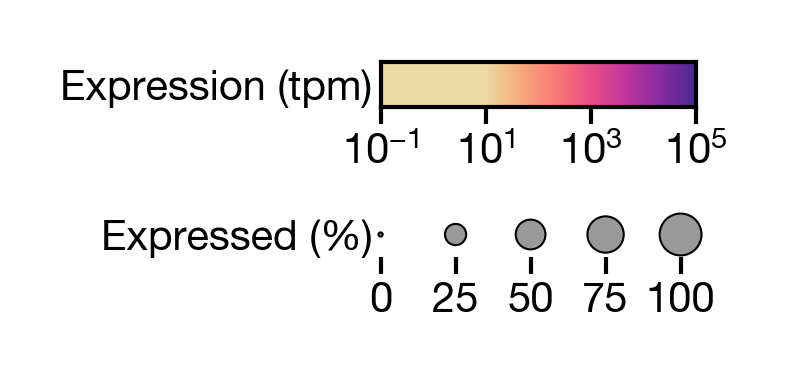

In [11]:
###### Colorbar
# 
#
fig = plt.figure(figsize=(1.5, 0.5), dpi=600)

cvmin, cvmax = vmin, vmax
colorbar_ax_position = [0.6, 0.7, 0.35, 0.15]
colorbar_ax = fig.add_axes(colorbar_ax_position,
                xscale='linear', yscale='linear', yticks=[0.5],
                xlabel='', ylabel='', frameon=True, )

gradient = np.linspace(-cvmin, cvmax, 256)
gradient = np.vstack((gradient, gradient))
colorbar_ax.imshow(gradient, aspect='auto', extent=(-cvmin,cvmax,0,1), 
            cmap=cmap, vmin=vmin, vmax=vmax)
colorbar_ax.tick_params(axis='y', which='major', length=0)

xticks = np.linspace(cvmin, cvmax, 3).astype(int)
xticks = [-1, 1, 3, 5]
colorbar_ax.set_xticks(xticks)
colorbar_ax.set_xticklabels(['10$^{' +str(xt)+'}$' for xt in xticks], fontsize=5);

colorbar_ax.set_yticklabels(['Expression (tpm)'], fontsize=5);

###### Expression % legend
# 
#

size_ax_position = [0.6, 0.2, 0.35, 0.15]
size_ax = fig.add_axes(size_ax_position,
                xscale='linear', yscale='linear', yticks=[0], xticks=range(5),
                xlabel='', ylabel='', frameon=False, )

size_ax.scatter(range(5), np.zeros(5), s=(np.linspace(0,1,5)*frac_scaling)+0.25, facecolor=core_colors.grey,
                edgecolor='k',linewidth=0.25, clip_on=False)
size_ax.set_xlim([0,4.2])
# 

size_ax.tick_params(axis='y', which='major', length=0)
size_ax.set_xticklabels(['0', '25', '50', '75', '100'], fontsize=5);

size_ax.set_yticklabels(['Expressed (%)'], fontsize=5);

fig.savefig(f'../../figures/components/extended_figure3/ExtendedFigure3C_legend.pdf', dpi=600, transparent=True)

In [17]:
samples = ['stage5.labels', 'stage6.labels', 'human_islets.labels', 'stage6.time_labels']
all_clusters = []
for s in samples:
    for cl in pb_tpm[s].index:
        all_clusters.append((s, cl))
        
stage6_islets_tpm = utils.combine_rows(pb_tpm, all_clusters)

In [18]:


comparison_tpm = stage6_islets_tpm.copy()


In [19]:
all_display_genes  = []
for ggi, (grp_title, grp_labelled, g_grp) in enumerate(gene_display_groups):
    all_display_genes += g_grp

In [21]:
expressed_display = comparison_tpm.loc['human_islets.labels beta'].copy()[all_display_genes] > 100
expressed_display = list(set(expressed_display[expressed_display].index))

598
33 55
269
6 55


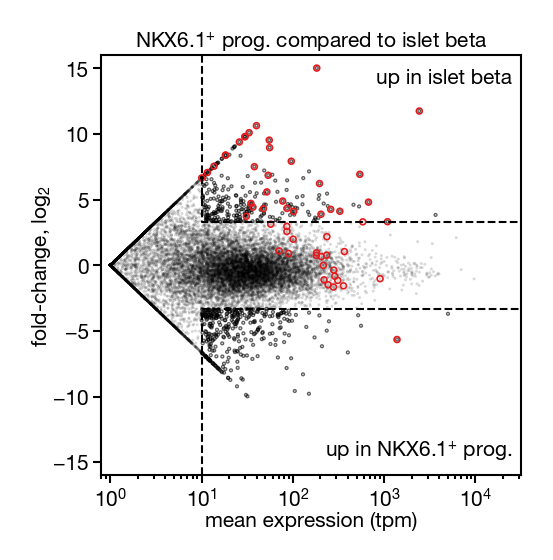

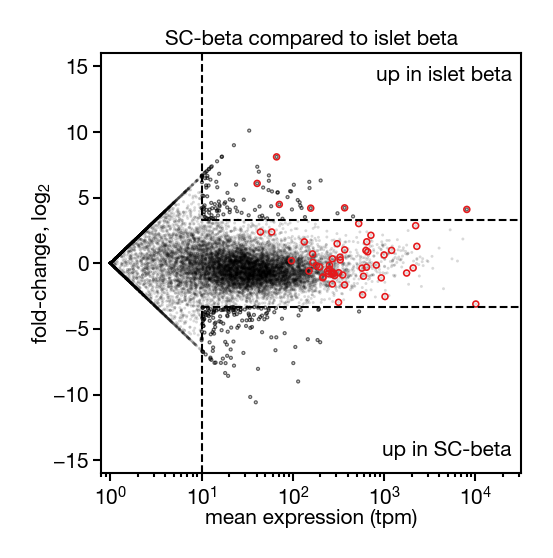

In [30]:


beta_cell_emphasis = [
    'INS', 
    'PDX1', 'MAFA', 'NKX6-1', 'PAX4', 'HOPX',
    'SLC2A2', 'GCK' ,'KCNJ11', 'ABCC8',
    'G6PC2','HADH', 'ROBO2','WSCD2','NPTX2','LRRTM3', 'PPM1E','CDKN1C','DLK1',
    'PCSK1', 'PCSK1N', 'PCSK2', 'CPE', 'SCG5', 'SLC30A8','CHGA','SYP','WFS1',
    'STX1A', 'VAMP2', 'SNAP25', 'STXBP1',
    'PTPRN', 'PTPRN2', 'GAD2', 
]


for fi,(name, cl) in enumerate([('NKX6.1$^{+}$ prog.', 'stage5.labels prog_nkx61'),
                                ('SC-beta', 'stage6.labels scbeta')]):
    

    g1 = comparison_tpm.loc[cl].copy()
    g2 = comparison_tpm.loc['human_islets.labels beta'].copy()
    fig = plt.figure(figsize=(2,2), dpi=300)
    ax = fig.add_axes([0.21, 0.15, 0.70, 0.70],
                      xscale='log', yscale='linear',
                    frameon=True)

    ax.set_xlabel('mean expression (tpm)', fontsize=5, labelpad=0)
    ax.set_ylabel('fold-change, $log_2$', fontsize=5, labelpad=0)
    ax.set_title(f'{name} compared to islet beta', fontsize=5, pad=2)


    g1[g1 < 1] = 1
    g2[g2 < 1] = 1

    gm = 10**((np.log10(g1)+np.log10(g2))/2)
    log_fc = np.log2(g2) - np.log2(g1)

    gm_thr = 10
    fc_thr = np.log2(10)

    de_genes = ((log_fc.abs() > fc_thr) & (gm > gm_thr))

    x = gm
    y = log_fc

    ax.scatter(x, y, c='k', s=0.5, edgecolor='none', 
               alpha=0.15, rasterized=True)

    ax.scatter(x[de_genes], y[de_genes], c='none', s=0.5, edgecolor='k', 
               alpha=0.6, linewidths = 0.3, rasterized=True)

    #
    # Drawing lines and setting up axis
    #


    xlims = [10**-0.1, 10**4.5]
    ylims = [-16, 16]
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    ax.plot([gm_thr, gm_thr, xlims[1]], [ylims[0], -fc_thr, -fc_thr], '--', linewidth=0.5, color='k')
    ax.plot([gm_thr, gm_thr, xlims[1]], [ylims[1], fc_thr, fc_thr], '--', linewidth=0.5, color='k') 

    
    ax.text(10**4.4, 15, 'up in islet beta', ha='right', va='top', fontsize=5)
    ax.text(10**4.4, -15, f'up in {name}', ha='right', va='bottom', fontsize=5)
    

    ax.scatter(x[expressed_display], y[expressed_display], c='none', s=2, edgecolor=core_colors.red, 
               alpha=1.0, linewidths = 0.4)

    
    subpanel = 'D' if fi==0 else 'E'
    fig.savefig(f'../../figures/components/extended_figure3/ExtendedFigure3{subpanel}.pdf', dpi=600, transparent=True)
    ax.tick_params(axis='both', which='minor', pad=1, width=0.5, zorder=-10, length=1)
    print(sum(de_genes))
    print(sum(de_genes[expressed_display]), len(expressed_display))

In [31]:
for v in ['Beta cell identity', 'Exocytosis', 'Metabolic sensing and signaling',
       'Maturation', 'MODY genes', 'Glucose sensing']:
    print(f"'{v}' : '{v}'")

'Beta cell identity' : 'Beta cell identity'
'Exocytosis' : 'Exocytosis'
'Metabolic sensing and signaling' : 'Metabolic sensing and signaling'
'Maturation' : 'Maturation'
'MODY genes' : 'MODY genes'
'Glucose sensing' : 'Glucose sensing'


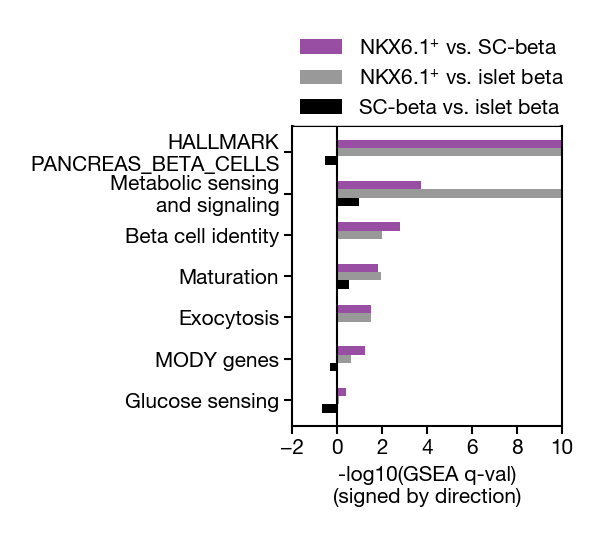

In [32]:
fig = plt.figure(figsize=(2.,2.), dpi=300)
ax = fig.add_axes([0.45, 0.25, 0.45, 0.50],
                  xscale='linear', yscale='linear',
                frameon=True)

ax.set_xlabel('-log10(GSEA q-val)\n(signed by direction)', fontsize=5, labelpad=2)


gs_order = ['Glucose sensing',   'MODY genes', 'Exocytosis', 'Maturation', 'Beta cell identity', 'Metabolic sensing and signaling',
       'HALLMARK_PANCREAS_BETA_CELLS']

gs_labels = {
'Beta cell identity' : 'Beta cell identity',
'Exocytosis' : 'Exocytosis',
'Metabolic sensing and signaling' : 'Metabolic sensing\nand signaling',
'Maturation' : 'Maturation',
'MODY genes' : 'MODY genes',
'Glucose sensing' : 'Glucose sensing',
'HALLMARK_PANCREAS_BETA_CELLS' : 'HALLMARK\nPANCREAS_BETA_CELLS'
}


ax.set_yticks(np.arange(len(gs_order)))
ax.set_yticklabels([gs_labels[g] for g in gs_order], fontsize=5)


w = 0.2
pos = np.arange(7)-w

gs_qval = utils.load_df('../04_Misc/data/gsea/custom_gene_set_summary.df.npz')

ax.barh(pos + 2*w, gs_qval['nkx61_v_scbeta'][gs_order], w, color=core_colors.purple,
        label='NKX6.1$^{+}$ vs. SC-beta')
ax.barh(pos+w, gs_qval['nkx61_v_beta'][gs_order], w, color=core_colors.grey,
        label='NKX6.1$^{+}$ vs. islet beta')
ax.barh(pos, gs_qval['scbeta_v_beta'][gs_order], w, color='k',
        label='SC-beta vs. islet beta')

plt.legend(bbox_to_anchor=(0., 1.0, 1., .102),
           ncol=1, mode="expand", borderaxespad=0., fontsize=5, edgecolor='none')


ax.set_xticks(np.arange(-2, 11,2))
# ax.set_xticklabels([-2, '', 0, '', 2, '', 4, '', 6, '', 8, '', 10])
ax.set_xlim([-2, 10])


# ax.tick_params(axis='both', which='major', pad=1, width=0.5, zorder=-10, length=2)
ax.axvline(0, lw=0.5, color='k')
fig.savefig(f'../../figures/components/extended_figure3/ExtendedFigure3F.pdf', dpi=600, transparent=True)